In [7]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/Users/kensukeumakoshi/Project/ML/data/creditcard.csv')


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


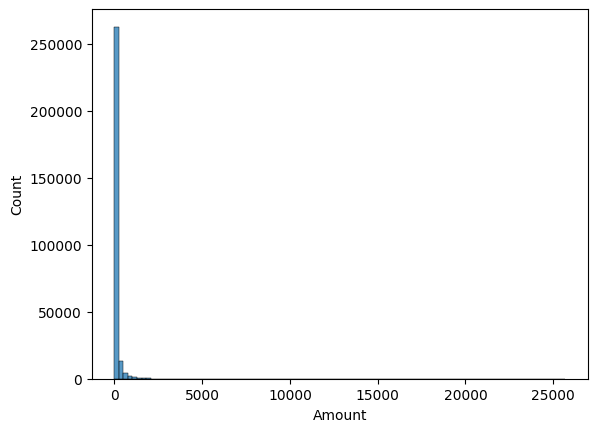

In [10]:
sns.histplot(df['Amount'], bins=100)
plt.show()

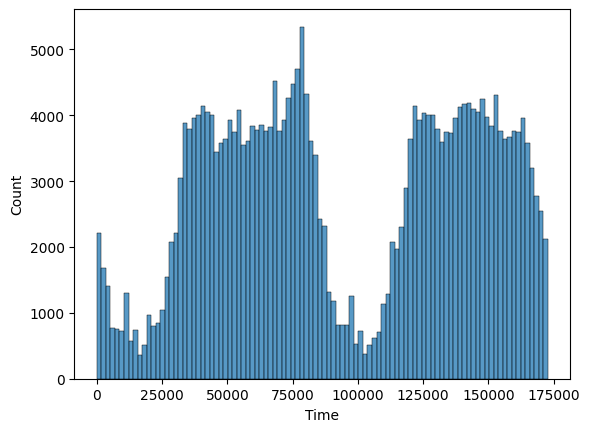

In [11]:
sns.histplot(df['Time'], bins=100)
plt.show()

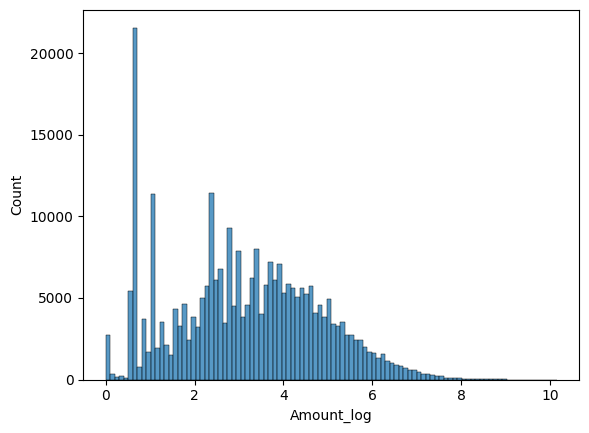

In [12]:
# log Amount 
import numpy as np
df['Amount_log'] = np.log1p(df['Amount'])
sns.histplot(df['Amount_log'], bins=100)
plt.show()

In [13]:
count = df['Class'].value_counts() / len(df) * 100
ratio_positive = count[0] / count[1]

In [14]:
df = df.drop(columns='Amount')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount_log
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.014760
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,1.305626
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.939276
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.824306
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.262539


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns='Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

rf_class = RandomForestClassifier(class_weight='balanced')
rf_class.fit(X_train, y_train)

y_pred = rf_class.predict(X_test)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# [[56862     2]
#  [   21    77]]
#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00     56864
#            1       0.97      0.79      0.87        98

#     accuracy                           1.00     56962
#    macro avg       0.99      0.89      0.93     56962
# weighted avg       1.00      1.00      1.00     56962


[[56863     1]
 [   24    74]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.76      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [17]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, rf_class.predict_proba(X_test)[:, 1])

In [21]:
auc

0.963257751398252

In [18]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score  # or accuracy_score
from sklearn.datasets import load_breast_cancer

In [19]:
def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    # min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    # min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    # max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        #min_samples_split=min_samples_split,
        #min_samples_leaf=min_samples_leaf,
        #max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred)  # or accuracy_score(y_test, y_pred)


# --- Run the optimization ---
# F1 is better when maximized
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

# --- Show results ---
print("Best hyperparameters:", study.best_trial.params)
print("Best F1 score:", study.best_value)

[I 2025-06-27 20:52:55,008] A new study created in memory with name: no-name-ba20e899-ef9b-4563-9848-0ec742fa5a5b
[I 2025-06-27 20:53:06,869] Trial 0 finished with value: 0.8390804597701149 and parameters: {'n_estimators': 97, 'max_depth': 7}. Best is trial 0 with value: 0.8390804597701149.
[I 2025-06-27 20:53:16,028] Trial 1 finished with value: 0.8390804597701149 and parameters: {'n_estimators': 66, 'max_depth': 8}. Best is trial 0 with value: 0.8390804597701149.
[I 2025-06-27 20:53:31,508] Trial 2 finished with value: 0.7590361445783133 and parameters: {'n_estimators': 216, 'max_depth': 4}. Best is trial 0 with value: 0.8390804597701149.


Best hyperparameters: {'n_estimators': 97, 'max_depth': 7}
Best F1 score: 0.8390804597701149


In [20]:
import optuna.visualization as vis

vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()